In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from iflow.dataset import gen_cycle_dataset
from data.human_robot_interaction_data.read_hh_hr_data import read_data
#from iflow.dataset.iros_dataset import IROS

import torch
import torch.optim as optim
from iflow.dataset import drums_dataset, gen_cycle_dataset, hr_cycle_dataset, hr_vel_cycle_dataset
from torch.utils.data import DataLoader
from iflow import model
from iflow.trainers import cycle_dynamics_train
from iflow.utils.generic import to_torch
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

from iflow.visualization import visualize_vector_field, visualize_trajectories
from iflow.test_measures.log_likelihood import cycle_log_likelihood

In [ ]:
batch_size = 100
depth_h = 3
depth_r = 3
## training variables ##

device = torch.device('cpu')

def main_layer(dim):
    return  model.ResNetCouplingLayer(dim)

def create_flow_seq(dim, depth):
    chain = []
    for i in range(depth):
        chain.append(main_layer(dim))
        chain.append(model.Permutation(torch.tensor([1,0, 2,3], dtype=torch.int32),1))
        chain.append(model.LULinear(dim))
    chain.append(main_layer(dim))
    return model.SequentialFlow(chain)

In [ ]:
data_p1_p, data_p1_q, names_p1, times_p1 = read_data('data/human_robot_interaction_data/hh/p1/hand_wave_s1_1.csv')
data_p2_p, data_p2_q, names_p2, times_p2 = read_data('data/human_robot_interaction_data/hh/p2/hand_wave_s2_1.csv')
segments = np.load('data/human_robot_interaction_data/hh/segmentation/hand_wave_1.npy')

In [ ]:
trajs_p1 = [data_p1_p[s[0]:s[1], :, :] for s in segments]
trajs_p2 = [data_p2_p[s[0]:s[1], :, :] for s in segments]

# downsample
stepsize = 1
cutoff = 400
offset = 140

trajs_p1_downsampled = np.array([a[::stepsize,:,:][offset:cutoff] for a in trajs_p1])
trajs_p1 = trajs_p1_downsampled.reshape(15,cutoff-offset,26*3)[:,:,-2:]

trajs_p2_downsampled = np.array([a[::stepsize,:,:][offset:cutoff] for a in trajs_p2])
trajs_p2 = trajs_p2_downsampled.reshape(15,cutoff-offset,26*3)[:,:,-2:]

dim_p1 = 2+2
dim_p2 = 2+2

trajs_p2 = trajs_p2[1:2]
trajs_p1 = trajs_p1[1:2]

plt.subplot(121)
for i in range(len(trajs_p1)):
    plt.scatter(trajs_p1[i,:,0],trajs_p1[i,:,1], c=np.arange(cutoff-offset))

a = np.arange(cutoff-offset)
plt.subplot(122)
for i in range(len(trajs_p2)):
    plt.scatter(trajs_p2[i,:,0],trajs_p2[i,:,1], c=a)

In [ ]:
from iflow.dataset import gen_cycle_dataset
d1 = gen_cycle_dataset.GENCYCLE(trajs_p1, 2)
d2 = gen_cycle_dataset.GENCYCLE(trajs_p2, 2)

In [ ]:
d1.w, d2.w

In [ ]:
vel_p1 = np.diff(trajs_p1, axis=1, prepend=trajs_p1[:1,:1,:])
vel_p2 = np.diff(trajs_p2, axis=1, prepend=trajs_p2[:1,:1,:])
trajs_vel_p1 = np.concatenate([trajs_p1, vel_p1], axis=2)
trajs_vel_p2 = np.concatenate([trajs_p2, vel_p2], axis=2)
data = hr_cycle_dataset.HRCycleDataset(trajs_vel_p1, trajs_vel_p2, dim_p1, dim_p2)

In [ ]:
data.w

In [ ]:
T_period = (2*np.pi)/data.w
params = {'batch_size': batch_size, 'shuffle': True}
dataloader = DataLoader(data, **params)

In [ ]:
x,y = next(iter(dataloader))
x[0].shape

In [ ]:
x[0].shape

In [ ]:
dim_p1, dim_p2

In [ ]:
def hr_cycle_dynamics_train(iflow, x, y):
    ## Separate Data ##
    y0 = x
    y1 = y[0]
    step = y[1][0]
    phase = y[2]
    ## Evolve dynamics forward ##
    x1_h, x1_r, log_det_J_x1_h, log_det_J_x1_r = iflow(y1)
    x0_h, x0_r, log_det_J_x0_h, log_det_J_x0_r = iflow(y0)

    x1 = torch.cat([x1_h, x1_r], dim=1)
    x0 = torch.cat([x0_h, x0_r], dim=1)

    ### Forward Conditioning ###
    log_p_z1 = iflow.dynamics.cartesian_cond_log_prob(x0, x1, T=step)
    log_trj = log_p_z1 + log_det_J_x1_h.squeeze() + log_det_J_x1_r.squeeze()

    ### Stable Point ###
    log_p_z0 = iflow.dynamics.stable_log_prob(x0, ref_phase=phase)
    log_stable = log_p_z0 + log_det_J_x0_h.squeeze() + log_det_J_x0_r.squeeze()

    log_total = torch.mean(log_stable) + torch.mean(log_trj)
    return -log_total

In [26]:
def train(depth, weight_decay=0.1, lr=0.001, nr_epochs=10_000, plotting=True, early_stopping=False):

    lsd = model.HRLinearLimitCycle(dim_p1, dim_p2, device, dt=data.dt, T_period=T_period).to(device)
    flow_human = create_flow_seq(dim_p1, depth).to(device)
    flow_robot = create_flow_seq(dim_p2, depth).to(device)
    iflow = model.HumanRobotFlow(dynamics=lsd, model_human=flow_human,
                                 model_robot=flow_robot).to(device)

    params = list(flow_human.parameters()) + list(flow_robot.parameters()) + list(lsd.parameters())
    optimizer = optim.Adam(params, lr = lr, weight_decay= weight_decay)

    likelihood_hist = []
    steps_hist = []

    for i in range(nr_epochs):
        # Training
        for local_x, local_y in dataloader:
            dataloader.dataset.set_step()
            optimizer.zero_grad()
            loss = hr_cycle_dynamics_train(iflow, local_x, local_y)
            loss.backward(retain_graph=True)
            #torch.nn.utils.clip_grad_norm_(parameters=iflow.parameters(), max_norm=10, norm_type=2.0)
            optimizer.step()

        if early_stopping:
            with torch.no_grad():
                iflow.eval()
                likelihood = loss.detach().item()
                print(likelihood)
                likelihood_hist.append(likelihood)
                steps_hist.append(i)
                if likelihood < 12:
                    break
                else:
                    continue

        ## Validation ##

    return iflow

In [29]:
trjs_h = []
trjs_r = []
for d in [1, 5, 10, 100]:
    iflow_model = train(d, weight_decay=0.1, lr=0.001, nr_epochs=2000, plotting=True, early_stopping=False)
    with torch.no_grad():
        iflow_model.eval()


        # plotting
        y0 = torch.from_numpy(data.train_data[0][0][None, :]).float().to(device)
        y0_h = y0[:, :dim_p1]
        y0_r = y0[:, dim_p1:]

        trj_h, trj_r = iflow_model.generate_trj(y0_h, y0_r, T=400)
        trj_h = trj_h.detach().cpu().numpy()
        trj_r = trj_r.detach().cpu().numpy()
        trjs_h.append(trj_h)
        trjs_r.append(trj_r)

    #plt.figure(figsize=(10,5))
    #plt.subplot(121)
    #for t in data.train_data[:, :, :data.dim_h]:
    #    plt.plot(t[:,0], t[:,1])

    #plt.plot(trj_h[:,0], trj_h[:,1], 'r')

    #plt.subplot(122)
    #for t in data.train_data[:, :, data.dim_h:]:
    #    plt.plot(t[:,0], t[:,1])
    #plt.plot(trj_r[:,0], trj_r[:,1], 'r')

    #plt.show()

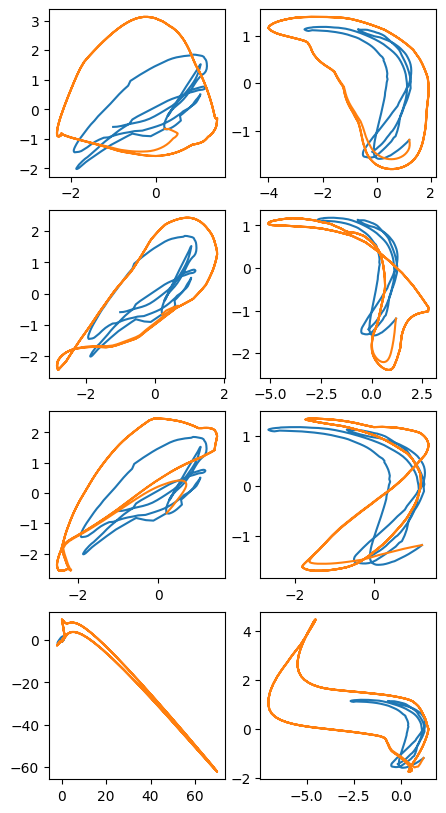

In [30]:
plt.figure(figsize=(5,10))
for i in range(len(trjs_h)):
    plt.subplot(len(trjs_h), 2, i*2+1)
    for t in data.train_data[:, :, :data.dim_h]:
        plt.plot(t[:,0], t[:,1])
    plt.plot(trjs_h[i][:, 0],trjs_h[i][:, 1])

    plt.subplot(len(trjs_h), 2, i*2+2)
    for t in data.train_data[:, :, data.dim_h:]:
        plt.plot(t[:,0], t[:,1])
    plt.plot(trjs_r[i][:, 0],trjs_r[i][:, 1])


In [ ]:
printasda

In [ ]:
lh, sh = [], []
depths = [1, 5, 10, 100]
for d in depths:
    likelihood_hist, steps_hist = train(d, weight_decay=0.1, lr=0.001, nr_epochs=1_000, plotting=False, early_stopping=False)
    lh.append(likelihood_hist)
    sh.append(steps_hist)

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(2,2)
fig.tight_layout(pad=1)
fig.set_size_inches(18, 18)
for i in range(2):
    for j in range(2):
        axs[i][j].set_title(f"depth: {depths[i*2+j]}")
        axs[i][j].set_xlabel("training steps")
        axs[i][j].set_ylabel("negative log log likelihood")
        axs[i][j].plot(sh[i+j], np.log(lh[i*2+j]))


In [ ]:
from tqdm import tqdm

lh, sh = [], []
params = []
lrs = [0.001, 0.005, 0.01]
wdecs = [0, 0.1, 0.5, 1]

for lr in tqdm(lrs):
    for w in tqdm(wdecs):
        for i in range(1):
            likelihood_hist, steps_hist = train(5, weight_decay=w, lr=lr, nr_epochs=3_000, plotting=True, early_stopping=True)
            lh.append(likelihood_hist)
            sh.append(steps_hist)
            params.append({"lr":lr, "w":w})

In [ ]:
for i, _ in enumerate(sh):

    print(len(sh[i]), params[i])